In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [3]:
# same as sklearn 
df = pd.read_csv("data/allHorizonData_cut.csv")

seq_features = [
    'r1', 'c1', 'rt1',
    'r2', 'c2', 'rt2',
    'r3', 'c3', 'rt3',
    'r4', 'c4', 'rt4'
]
static_features = ['gameLength', 'uc']

target = 'c5'

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]
y = y-1 # binary CE only takes in 0, 1

X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)

# split based on original data frame
h1_mask = X_static_test['gameLength'] == 5
h6_mask = X_static_test['gameLength'] == 10
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())

--- Feature Data (X) ---
   r1  c1       rt1  r2  c2       rt2  r3  c3       rt3  r4  c4       rt4
0  66   2  1.849054  80   2  1.771619  29   1  0.562676  75   2  0.578808
1  69   2  0.967068  50   2  0.495166  51   1  0.506639  64   2  0.460037
2  31   2  0.862793  43   1  0.490816  26   2  0.924838  36   1  0.951034
3  65   1  6.272626  77   2  1.204784  52   2  0.795462  73   1  0.457327
4  70   2  0.614185  19   1  0.364167  43   2  0.306713  41   1  0.372321
   gameLength  uc
0           5   3
1          10   3
2          10   2
3          10   2
4          10   2

--- Target Data (y) ---
0    1
1    0
2    0
3    0
4    1
Name: c5, dtype: int64


In [4]:
feature_order_test = np.array(seq_features).reshape(-1, 4, 3)
print(feature_order_test)

[[['r1' 'c1' 'rt1']
  ['r2' 'c2' 'rt2']
  ['r3' 'c3' 'rt3']
  ['r4' 'c4' 'rt4']]]


In [5]:
print(X_seq_train.shape)
print(type(X_seq_train))
print(type(y_train))

(15360, 12)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


convert to tensor for pytorch

In [6]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, 3)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, 3)
print(X_seq_test.shape)
print(type(X_seq_test))

(15360, 4, 3)
<class 'numpy.ndarray'>
[[-0.04839109 -1.00326052 -0.06340892]
 [ 1.97202053  0.98706284 -0.09338387]
 [ 1.12278856  1.00430615 -0.11580627]
 [ 1.3450348   1.00928792 -0.16394309]]
(3840, 4, 3)
<class 'numpy.ndarray'>


In [7]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [8]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [9]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask, dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask, dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [10]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [11]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [12]:
class RNN(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(seq_input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, h_n = self.rnn(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output


In [13]:
class LSTM(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=128, output_size=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 64), # combine static inputs
            nn.GELU(),
            nn.Linear(64, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, (h_n, c_n) = self.lstm(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [14]:
class GRU(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

# train / eval

In [15]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(seq_inputs, static_inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            preds = model(seq_inputs, static_inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# running experiment

In [16]:
model = GRU().to(device)
print(model)

GRU(
  (gru): GRU(3, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=66, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
epochs = 20
loss_prog = []
acc_prog = []
acc_h1_prog = []
acc_h6_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    acc_h1 = test(model, test_loader_h1, device)
    acc_h6 = test(model, test_loader_h6, device)
    print(f"Epoch {epoch+1}: Loss: {loss:.4f} | overall: {acc:.4f} | H1 {acc_h1:.4f} | H6 {acc_h6:.4f}")

    loss_prog.append(loss)
    acc_prog.append(acc)
    acc_h1_prog.append(acc_h1)
    acc_h6_prog.append(acc_h6)

Epoch 1: Loss: 0.5695 | overall: 0.7948 | H1 0.8368 | H6 0.7521
Epoch 2: Loss: 0.4875 | overall: 0.7937 | H1 0.8404 | H6 0.7463
Epoch 3: Loss: 0.4783 | overall: 0.8003 | H1 0.8440 | H6 0.7558
Epoch 4: Loss: 0.4733 | overall: 0.7974 | H1 0.8435 | H6 0.7505
Epoch 5: Loss: 0.4693 | overall: 0.7966 | H1 0.8409 | H6 0.7516
Epoch 6: Loss: 0.4673 | overall: 0.7987 | H1 0.8487 | H6 0.7479
Epoch 7: Loss: 0.4649 | overall: 0.7977 | H1 0.8492 | H6 0.7453
Epoch 8: Loss: 0.4632 | overall: 0.7969 | H1 0.8445 | H6 0.7484
Epoch 9: Loss: 0.4617 | overall: 0.7922 | H1 0.8352 | H6 0.7484
Epoch 10: Loss: 0.4601 | overall: 0.7953 | H1 0.8399 | H6 0.7500
Epoch 11: Loss: 0.4582 | overall: 0.7961 | H1 0.8450 | H6 0.7463
Epoch 12: Loss: 0.4568 | overall: 0.7964 | H1 0.8471 | H6 0.7447
Epoch 13: Loss: 0.4561 | overall: 0.7953 | H1 0.8440 | H6 0.7458
Epoch 14: Loss: 0.4537 | overall: 0.7919 | H1 0.8394 | H6 0.7437
Epoch 15: Loss: 0.4527 | overall: 0.7927 | H1 0.8404 | H6 0.7442
Epoch 16: Loss: 0.4509 | overall: 

In [19]:
import matplotlib.pyplot as plt

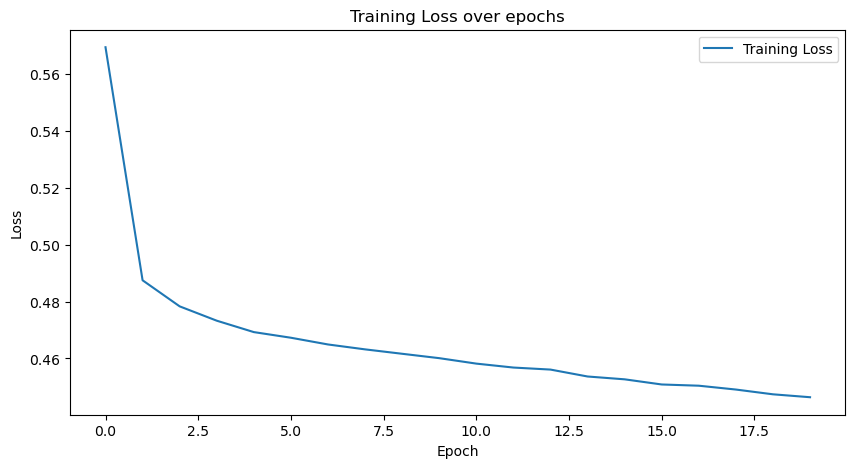

In [20]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

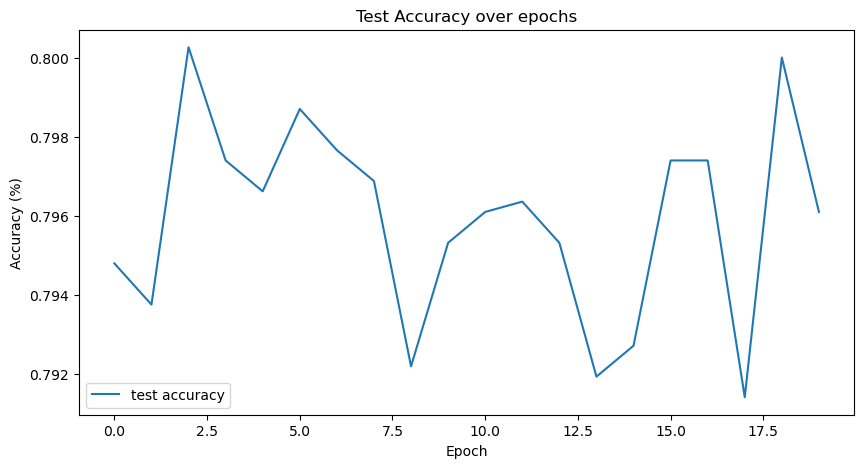

In [21]:
# plot testing accuracy
def plot_accuracy(accuracy_progress_list):
    plt.figure(figsize=(10, 5))
    for label, acc in accuracy_progress_list:
        plt.plot(range(epochs), acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over epochs')
    plt.legend()
    plt.show()

plot_accuracy([('test accuracy', acc_prog)])

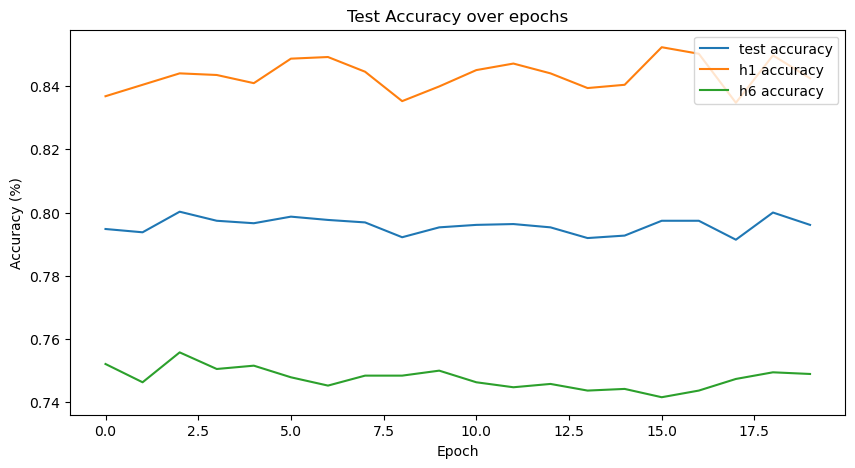

In [22]:
plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])